## References
- https://machinelearningmastery.com/time-series-data-stationary-python/

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

_INPUT_DATA_PATH = ['dataset/FC_2021-03.csv',
                    'dataset/FC_2021-04.csv',
                    'dataset/FC_2021-05.csv',
                    'dataset/FC_2021-06.csv']

In [30]:
### 
#   1. read data   
### 
df = pd.DataFrame()
for data_path in _INPUT_DATA_PATH:
    temp_df = pd.read_csv(data_path, low_memory=False, dtype={
                     'BKG_DATE': str, 'BKG_TIME': str, 'POST_ZONE': str
                 })
    df = pd.concat([df, temp_df], ignore_index=True)

    print(data_path, "\t", temp_df.shape)

print(df.info())

dataset/FC_2021-03.csv 	 (309352, 32)


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

KX007 = 곤지암만 고려함

In [4]:
_cols = {'CORP_ID', 'BKG_NO', 'INS_ID', 'INS_DATE', 'INS_TIME', 'BRAND_NM',
         'ORDER_IDX', 'ORDER_YN', 'SPLIT_EXEC_YN', 'DLVCLSFCD', 'DLVSUBCLSFCD', 
         'DLVPREARRBRANCD', 'DLVPREARREMPNICKNM', 'DLV_DV', 'REF_ITEM_SEQ', 'IF_YN',
         'ORDER_CRT_DATETIME', 'SHPR_ADDR_1', 'SHPR_ADDR_2', 'CNEE_ADDR_1', 'CNEE_ADDR_2'}

fc_kx = df.loc[df['CORP_ID'] == 'KX007'].drop(columns=_cols)
fc_kx.head(80)

,REF_ORD_NO,BKG_TYP,BKG_DATE,BKG_TIME,SHPR_CD,INV_AMT,ITEM_SEQ,ITEM_CD,ITEM_QTY,ITEM_AMT,POST_ZONE
0,2021030365922551,7,20210303,035510,90001302,22400.0,2,134265392,1,14900.0,03
1,2021030365922951,7,20210303,035521,90001441,20900.0,1,4610261043_2,1,20900.0,50
2,2021030365924361,7,20210303,035513,90001441,37900.0,1,4936599538_1,1,37900.0,53
3,2021030365928921,7,20210303,035608,90001542,69800.0,1,3858391637_1,1,69800.0,06
4,2021030365930451,7,20210303,035551,90001341,73700.0,1,4631307460,1,39800.0,10
...,...,...,...,...,...,...,...,...,...,...,...
75,2021030118012281,7,20210301,001334,90001302,98200.0,1,5390871219,1,12300.0,31
76,2021030118012281,7,20210301,001334,90001302,98200.0,2,5390889017,1,11300.0,31
77,2021030118012281,7,20210301,001334,90001302,98200.0,3,2756258776_2,1,19900.0,31
78,2021030118012281,7,20210301,001334,90001302,98200.0,4,5390938207_2,1,27800.0,31


In [5]:
fc_kx.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1606010 entries, 0 to 1786355
Data columns (total 11 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   REF_ORD_NO  1606010 non-null  object 
 1   BKG_TYP     1606010 non-null  int64  
 2   BKG_DATE    1606010 non-null  object 
 3   BKG_TIME    1606010 non-null  object 
 4   SHPR_CD     1606010 non-null  int64  
 5   INV_AMT     1580274 non-null  float64
 6   ITEM_SEQ    1606010 non-null  int64  
 7   ITEM_CD     1606010 non-null  object 
 8   ITEM_QTY    1606010 non-null  int64  
 9   ITEM_AMT    1587419 non-null  float64
 10  POST_ZONE   1605000 non-null  object 
dtypes: float64(2), int64(4), object(5)
memory usage: 147.0+ MB


# To Do 

데이터셋 링크
https://1drv.ms/u/s!Am13uPWZVWlVndF1ztqWmBuzX9mJQw?e=aZqP82

@WS Jung <br>
fc_kx 데이터를 대상으로 학습데이터 생성 (~10/17)

1. BKG_DATE 기준 일 별로 데이터 포인트 생성(총 120개)
2. INV_AMT & ITEM_AMT = (고객사 별 구분) Quantile 기준 값 생성 
3. ITEM_CD = (고객사 별 구분) 출현 빈도 수 
4. POST_ZONE = 카테고리 값
5. 휴일 여부 (1 or 0)
6. 월요일 여부 (1 or 0)

@HT Kim <br>
ARIMA 기준으로 파이프라인 모델 배포해서 값 나오는 것 (~10/14 on AWS)

In [6]:
# 센터별 고객사 확인
fc_kx['SHPR_CD'].unique()

array([90001302, 90001441, 90001542, 90001341, 90001541, 90001443,
       90001381, 90001521, 90001502, 90001562, 90001582, 90001602,
       90001683, 90001622, 90001662, 90001682])

In [15]:
# datetime으로 변환
# fc_kx['BKG_DATE'] = pd.to_datetime(fc_kx['BKG_DATE'])
# fc_kx['BKG_TIME'] = pd.to_datetime(fc_kx['BKG_TIME'])

fc_kx['BKG_DATE'] = pd.to_datetime(fc_kx['BKG_DATE'])
fc_kx['BKG_TIME'] = pd.to_datetime(fc_kx['BKG_TIME'], format="%H%M%S").dt.time


In [17]:
kx = fc_kx[['REF_ORD_NO','BKG_DATE','SHPR_CD']]
kx = kx.groupby(['SHPR_CD','BKG_DATE']).count()
kx = kx.rename(columns={'REF_ORD_NO':'Count'})
kx = kx.reset_index()
kx

,SHPR_CD,BKG_DATE,Count
0,90001302,2021-03-01,2190
1,90001302,2021-03-02,3822
2,90001302,2021-03-03,1844
3,90001302,2021-03-04,1698
4,90001302,2021-03-05,1501
...,...,...,...
1370,90001683,2021-06-26,93
1371,90001683,2021-06-27,246
1372,90001683,2021-06-28,84
1373,90001683,2021-06-29,64


특정 고객사만 처리

In [18]:
kx1302 = kx[kx['SHPR_CD'] == 90001302]
kx1441 = kx[kx['SHPR_CD'] == 90001441]
kx1542 = kx[kx['SHPR_CD'] == 90001542]
kx1341 = kx[kx['SHPR_CD'] == 90001341]
kx1541 = kx[kx['SHPR_CD'] == 90001541]
kx1443 = kx[kx['SHPR_CD'] == 90001443]
kx1521 = kx[kx['SHPR_CD'] == 90001521]
kx1502 = kx[kx['SHPR_CD'] == 90001502]
kx1582 = kx[kx['SHPR_CD'] == 90001582]

kx1302 고객사

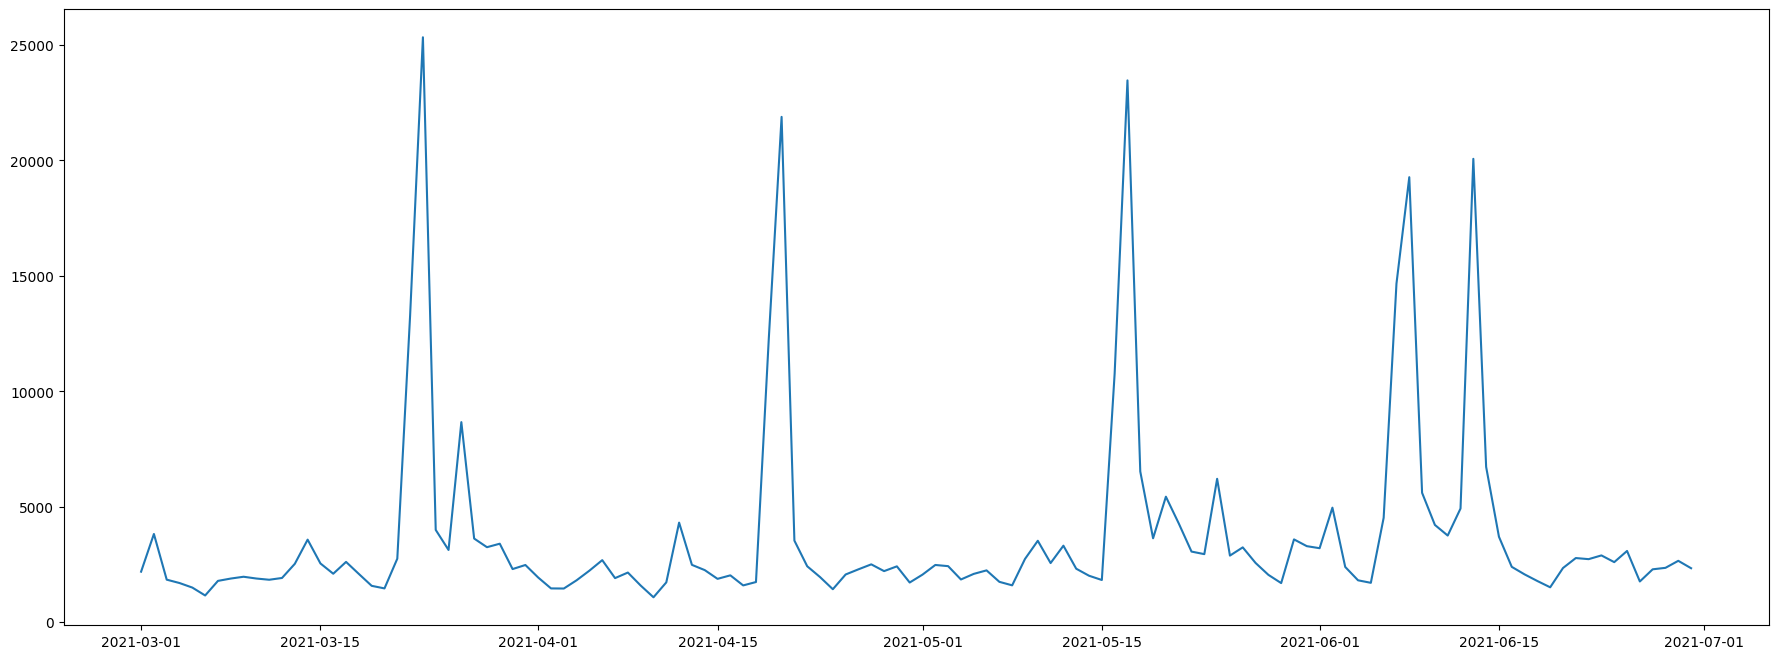

In [19]:
plt.figure(figsize=(22,8))
x = kx1302['BKG_DATE']
y = kx1302['Count']
plt.plot(x,y)

### Check Stationary

In [22]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [24]:
check_stationarity(kx1302['Count'])

ADF Statistic: -7.133907
p-value: 0.000000
Critical Values:
	1%: -3.486
	5%: -2.886
	10%: -2.580
Stationary


### ACF PACF 확인

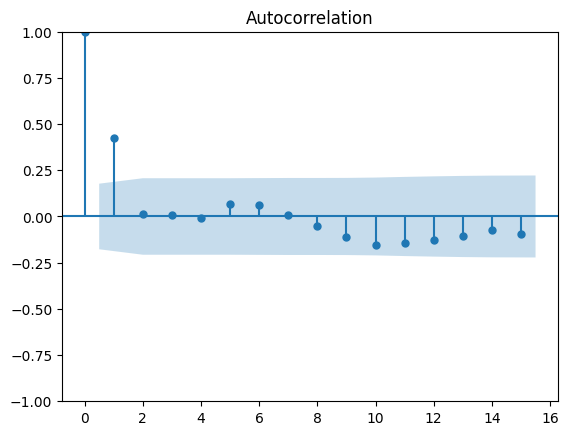

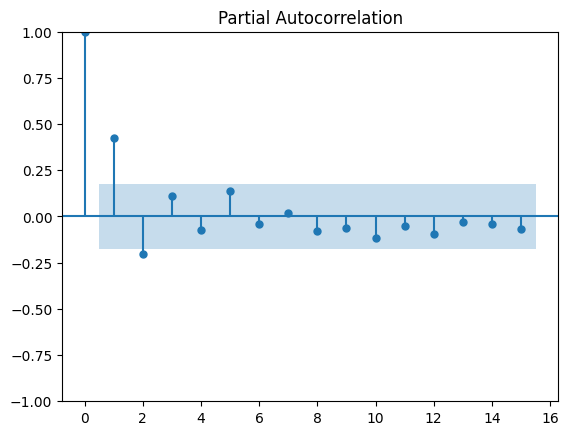

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(kx1302['Count'], lags = 15)
plot_pacf(kx1302['Count'], lags = 15, method = "ols")


plt.show()

In [26]:
# 학습 데이터 선정
series = kx1341['Count']

predicted=1259.756107, expected=1198.000000
predicted=1275.126987, expected=1017.000000
predicted=1215.145379, expected=866.000000
predicted=1194.469940, expected=2734.000000
predicted=1742.819354, expected=11089.000000
predicted=4620.826827, expected=1237.000000
predicted=-179.282008, expected=1239.000000
predicted=1408.070203, expected=1466.000000
predicted=1423.227062, expected=1246.000000
predicted=1354.531813, expected=1414.000000
predicted=1417.659382, expected=759.000000
predicted=1244.437544, expected=712.000000
predicted=1299.892204, expected=1199.000000
predicted=1405.958989, expected=1286.000000
predicted=1371.878846, expected=1442.000000
predicted=1403.583534, expected=1065.000000
predicted=1299.212643, expected=1194.000000
predicted=1369.249589, expected=681.000000
predicted=1228.997871, expected=584.000000
predicted=1256.016583, expected=970.000000
predicted=1344.097792, expected=1111.000000
predicted=1331.660766, expected=1251.000000
predicted=1352.829493, expected=1039.

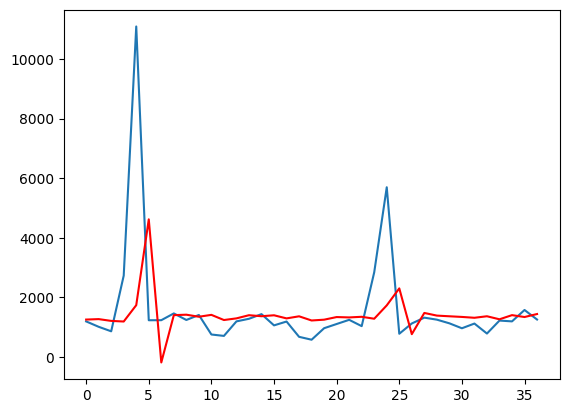

In [28]:
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
from sklearn.metrics import mean_squared_error

# split into train and test sets
X = series.values
size = int(len(X) * 0.7)

train, test = X[0:size], X[size:len(X)]
history = [x for x in train]

predictions = list()

# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(2,0,1))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)


# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()